<a href="https://colab.research.google.com/github/BankNatchapol/Quantum-POW/blob/main/QPOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install pylatexenc

# **Blockchain Classical Proof of Work**
In the classical Blockchain, Proof of Work protocol use to confirm transactions and produce new blocks to the chain. 
<img src="https://www.ledger.com/wp-content/uploads/2019/10/What-is-proof-of-work-1.jpg">
## How it work?
First, we have these blocks.
<img src="http://spheregen.com/wp-content/uploads/2019/04/blockchain.png"><br>
Each block contains the data of previous block hash and their own hash. <br>
with<br><br>
$$ Target = SHA256(SHA256(Previous Hash || nonce))$$<br>
To create new block you need to randomly find number(nonce) that makes this equation true.<br><br>
$$ Target > SHA256(SHA256(Previous Hash || nonce)) $$<br>
When you found the nonce, you can create new block and get reward.

In [ ]:
import hashlib

# define block component
previous_hash="98cd56fde9583ca4acc490d8ce3f8f0f6bbaf9e2f956d60c4756414a575741ef" 
real_nonce = "100"

Difficulty use to reduce hash rate.

In [ ]:
difficulty = 3

Combine block components together.

In [ ]:
encoded = (previous_hash + real_nonce).encode()
first_encoded = hashlib.sha256(encoded)
second_encoded =  hashlib.sha256(first_encoded.hexdigest().encode())
target = second_encoded.hexdigest()
print(target)

f08ab4c9bc26530f664f38d2d03c1ffbf0247d03d9524d1f0973954fa38e67aa


In [ ]:
l_target = list(target)
l_target[:difficulty] = "0"*difficulty
d_target = "".join(l_target)
print(d_target)

000ab4c9bc26530f664f38d2d03c1ffbf0247d03d9524d1f0973954fa38e67aa


Mining algorithm

In [ ]:
random_nonce = 0 # generate random nonce

while True:

  # use previous block hash and random nonce to estimate target
  encoded = (previous_hash + str(random_nonce)).encode()
  first_encoded = hashlib.sha256(encoded)
  second_encoded =  hashlib.sha256(first_encoded.hexdigest().encode())

  # check if our solution is less than target
  if second_encoded.hexdigest() < d_target:
    result = {"random_nonce":random_nonce, "solution":second_encoded.hexdigest()}
    print("You receive 1 Bitcoin!!\n")
    break

  random_nonce += 1 

print(result)

You receive 1 Bitcoin!!

{'random_nonce': 8409, 'solution': '00068b834ab331a2e3e0f33bd7c4b26f08374eafffc6dae0f558636972fd85cc'}


# **Blockchain Quantum Proof of Work**
In my Quantum Proof of Work protocol, i will map nonce into sequence of quantum gate and hash into binary number.
<br>
Algorithm:
<img src="https://github.com/BankNatchapol/Quantum-POW/blob/main/static/QPOW.png?raw=true">


In [ ]:
import numpy as np
from qiskit import *
from itertools import permutations

**Define initial parameter.** <br>
num_qubits: size of hash<br>
valid_gate: available quantum gate <br>
previous_hash: initial hash value

In [ ]:
num_qubits = 4
valid_gate = ["X", "Y", "Z", "H"]

previous_hash = "XHZH"

In [ ]:
def apply_qgate(quantum_circuit, gate, qubit):
  """
    function for map hash value into quantum gate.
    Parameters:
      quantum_circuit: Qiskit QuantumCircuit object
      gate: single hash value
      qubit: qubit No.  
    
    Return: 
      -
  """

  if gate == "X":
    quantum_circuit.x(qubit)
  elif gate == "Y":
    quantum_circuit.y(qubit)
  elif gate == "Z":
    quantum_circuit.z(qubit)
  elif gate == "H":
    quantum_circuit.h(qubit)
  else:
    assert 0, f"{gate} gate is not recognized."

Apply quantum gate from hash value into quantum circuit.

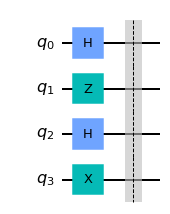

In [ ]:
target_circuit = QuantumCircuit(num_qubits)

for i in range(num_qubits):
  apply_qgate(target_circuit, previous_hash[-(i+1)], i)

target_circuit.barrier()
target_circuit.draw("mpl")

Define our own random nonce.

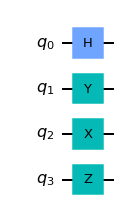

In [ ]:
random_nonce = "ZXYH"
nonce_circuit = QuantumCircuit(num_qubits)

for i in range(num_qubits):
  apply_qgate(nonce_circuit, random_nonce[-(i+1)], i)

nonce_circuit.draw("mpl")

Combined target circuit with nonce circuit.

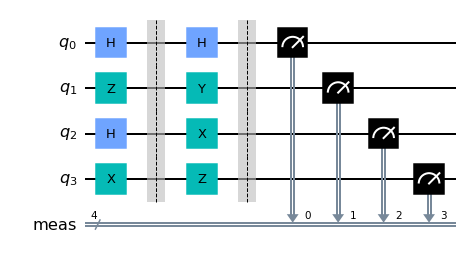

In [ ]:
answer_circuit = (target_circuit + nonce_circuit)
answer_circuit.measure_all()
answer_circuit.draw("mpl")

In [ ]:
backend = Aer.get_backend('qasm_simulator')

job = execute(answer_circuit, backend)

result = job.result()

outputstate = result.get_counts()
print(outputstate)


{'1110': 495, '1010': 529}


In [ ]:
hash_circuit = QuantumCircuit(num_qubits)

hash_circuit.measure_all()
hash_circuit.draw("mpl")

backend = Aer.get_backend('qasm_simulator')

job = execute((target_circuit+hash_circuit), backend)

result = job.result()

outputstate = result.get_counts()
print(outputstate)

{'1000': 239, '1001': 255, '1100': 263, '1101': 267}


In [ ]:
def cal_hash(outputstate):
  target_hash = 0
  for state in outputstate:
    target_hash += int(state,2) 

  target_hash_bin = bin(target_hash)
  if len(target_hash_bin) > num_qubits +2:
    target_hash_bin = "0b" + target_hash_bin[-num_qubits:]
  return target_hash_bin

target_hash_bin = cal_hash(outputstate)
print("Target Hash :", target_hash_bin)

Target Hash : 0b1010


In [ ]:
difficulty = 2
l_target = list(target_hash_bin)
l_target[2:difficulty+2] = "0"*difficulty
target_hash_bin = bin(int("".join(l_target), 2))
target_hash_bin

'0b10'

Runing mining algorithm.

In [ ]:
list_combinations = ""
for gate in valid_gate:
  list_combinations += gate*num_qubits
all_answer_nonce = permutations(list_combinations, num_qubits)


for t, answer_nonce in enumerate(all_answer_nonce):
  nonce_circuit = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    apply_qgate(nonce_circuit, answer_nonce[-(i+1)], i)
  backend = Aer.get_backend('qasm_simulator')

  answer_circuit = (target_circuit + nonce_circuit)
  answer_circuit.measure_all()

  job = execute(answer_circuit, backend)

  result = job.result()
  if t%10 == 0:
    print("Iter :", t)
    
  outputstate = result.get_counts()
  if bin(int(cal_hash(outputstate),2)) < target_hash_bin:
    print("You reveive 1 QuantumCoin!!")
    break
      


Iter : 0
Iter : 10
Iter : 20
Iter : 30
Iter : 40
Iter : 50
Iter : 60
Iter : 70
Iter : 80
Iter : 90
Iter : 100
Iter : 110
Iter : 120
Iter : 130
Iter : 140
Iter : 150
Iter : 160
Iter : 170
Iter : 180
Iter : 190
Iter : 200
Iter : 210
Iter : 220
Iter : 230
Iter : 240
Iter : 250
Iter : 260
Iter : 270
Iter : 280
Iter : 290
Iter : 300
Iter : 310
Iter : 320
Iter : 330
Iter : 340
Iter : 350
Iter : 360
Iter : 370
Iter : 380
Iter : 390
Iter : 400
Iter : 410
Iter : 420
Iter : 430
Iter : 440
Iter : 450
Iter : 460
Iter : 470
Iter : 480
Iter : 490
Iter : 500
Iter : 510
Iter : 520
Iter : 530
Iter : 540
Iter : 550
Iter : 560
Iter : 570
Iter : 580
Iter : 590
Iter : 600
Iter : 610
Iter : 620
Iter : 630
Iter : 640
Iter : 650
Iter : 660
Iter : 670
Iter : 680
Iter : 690
Iter : 700
Iter : 710
Iter : 720
Iter : 730
Iter : 740
Iter : 750
Iter : 760
Iter : 770
Iter : 780
Iter : 790
Iter : 800
Iter : 810
Iter : 820
Iter : 830
Iter : 840
Iter : 850
Iter : 860
Iter : 870
Iter : 880
Iter : 890
Iter : 900
Iter : 910

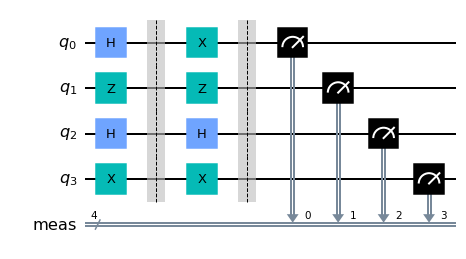

In [ ]:
answer_circuit.draw("mpl")

Answer nonce.

In [ ]:
quantum_nonce = ""
for i in nonce_circuit.data:
  quantum_nonce = i[0].name.upper() + quantum_nonce
quantum_nonce

'XHZX'

Answer Hash.

In [ ]:
current_hash = bin(int(cal_hash(outputstate),2))

def bin_correction(hash):
  if len(str(hash)) < 2 + num_qubits:
    hash = "0b" + "0"*(2 + num_qubits - len(str(hash))) + str(hash)[2:]
  return hash

current_hash = bin_correction(current_hash)
current_hash

'0b0001'

In [ ]:
full_header = current_hash + quantum_nonce 
print(full_header)

0b0001XHZX


In [ ]:
target_hash_bin = bin_correction(target_hash_bin)
previous_header = target_hash_bin + previous_hash
print(previous_header)

0b0010XHZH


Block chain.

In [ ]:
print(previous_header, " -> ", full_header)

0b0010XHZH  ->  0b0001XHZX
